<a href="https://colab.research.google.com/github/lucia990/ADM_GROUP-30_HW_4/blob/Lucia/LuciaADM_Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ADM_HW_4')

In [ ]:
!pwd

/content/drive/MyDrive/ADM_HW_4


In [ ]:
!kaggle datasets download -d shivamb/bank-customer-segmentation

 62% 15.0M/24.2M [00:00<00:00, 152MB/s]
100% 24.2M/24.2M [00:00<00:00, 168MB/s]


In [ ]:
!unzip bank-customer-segmentation.zip

Archive:  bank-customer-segmentation.zip
  inflating: bank_transactions.csv   


###Inspect the dataset

In [ ]:
#create the dataframe
import pandas as pd
data = pd.read_csv('bank_transactions.csv', usecols = ['CustomerID', 'CustomerDOB','CustGender',	'CustLocation',	'CustAccountBalance', 'TransactionDate', 'TransactionTime',	'TransactionAmount (INR)'])
#drop the columns containing transaction and customer IDs since they are not useful information for similarity detection 

In [ ]:

#group by the customer id. For each of them we pick the last transaction
customer_data = data.groupby('CustomerID').last()
customer_data.reset_index(drop = True, inplace = True)

In [ ]:
#check how many missing values there are in the dataset
customer_data.isna().sum()

CustomerDOB                2372
CustGender                  803
CustLocation                114
CustAccountBalance         1665
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [ ]:
customer_data.dropna(inplace= True)
customer_data.reset_index(drop = True, inplace = True)

In [ ]:
customer_data.isna().sum()

CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

Now we want the data in each column to be of the types we can manipulate better. 


#### Transaction Date

In [ ]:
#we want the date to be of datetime type
customer_data['TransactionDate'] = pd.to_datetime(customer_data.TransactionDate)

In [ ]:
customer_data.TransactionDate

0        2016-09-08
1        2016-08-14
2        2016-07-08
3        2016-09-15
4        2016-08-18
            ...    
879354   2016-07-08
879355   2016-09-15
879356   2016-08-18
879357   2016-08-28
879358   2016-09-25
Name: TransactionDate, Length: 879359, dtype: datetime64[ns]

In [ ]:
customer_data.TransactionDate.dt.year.value_counts()


2016    879359
Name: TransactionDate, dtype: int64

We see that our dataset deals with transactions in 2016. 

#### Date of Birth

In [ ]:

customer_data.CustomerDOB[29]

'20/4/90'

In [ ]:
#we want the date to be of datetime type
customer_data['CustomerDOB'] = pd.to_datetime(customer_data.CustomerDOB)

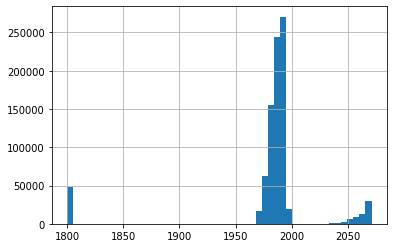

In [ ]:
customer_data.CustomerDOB.dt.year.hist(bins= 50)

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year == 1800, 'CustomerDOB']

16       1800-01-01
28       1800-01-01
49       1800-01-01
78       1800-01-01
85       1800-01-01
            ...    
879309   1800-01-01
879311   1800-01-01
879317   1800-01-01
879325   1800-01-01
879328   1800-01-01
Name: CustomerDOB, Length: 47541, dtype: datetime64[ns]

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'].sort_values()

181206   2018-03-05
210272   2019-12-15
427436   2019-12-15
4230     2019-12-15
177641   2019-12-15
            ...    
872086   2071-12-30
500052   2071-12-30
315875   2071-12-30
464861   2071-12-31
334142   2071-12-31
Name: CustomerDOB, Length: 63124, dtype: datetime64[ns]

We notice something weird: according to this dataset there are customer born in 1800 and after 2016. This is very unlikely: maybe for that customer the date of birth was missing and replaced with a default one. What we can do is dropping the corresponding rows (but we see that in this way we are going to lose more than 130000 transactions) or "fix" the data. Since we have to hash the customer, we want the data to be fixed in a way that does not compromise the results of the hashing operation. 

We notice also that the DOB in 1800 have the same exact date, unlike the successive DOB, so maybe it is better to correct them with different approaches:
- for DOB > 2016 we simply subtract 100 years in order to assign a likely date of birth. Of course this represents an issue for finding similar customers, but better than dropping all the information related to these transactions. 
- for DOB = **1800-01-01** we need to replace the date of birth with the customer resulting the most similar to the customers whos DOB is wrong. 

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'] = customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'].count()

0

We fixed the first problem. We want to find a way to fix the second. If we find some common feature for all those transactions with equal DOB we can deduct a solution for dealing with them. 
In this part, we create a subset of the dataframe containing only the transactions with the wrong date of birth and find common features among them. The chosen date of birth chosen for all these transactions will be the DOB of the customer having these common features.  

In [ ]:
#dataframe containing only the data with the wrong date of birth
#This dataframe will help us finding similar behaviors among the customers
sub_data = customer_data.loc[customer_data.CustomerDOB.dt.year == 1800]

For the majority, the wrong date are related to male customers. 

In [ ]:
sub_data.CustAccountBalance.mean()

268667.53402389516

In [ ]:
sub_data.CustLocation.value_counts()

NEW DELHI                             6560
MUMBAI                                3700
BANGALORE                             3044
DELHI                                 2685
GURGAON                               2628
                                      ... 
COLLEGE KEMPAPURA HEBBAL BANGALORE       1
CHINCHWAD PUNE                           1
RAMDEV TEMPLE RANGAREDDY                 1
DARYA GANJ NEW DELHI                     1
NARNAUL                                  1
Name: CustLocation, Length: 1603, dtype: int64

In [ ]:
sub_data['TransactionAmount (INR)'].value_counts()

1000.00    2293
500.00     1755
2000.00     950
200.00      910
100.00      845
           ... 
5446.00       1
9426.00       1
1165.50       1
7209.68       1
9511.36       1
Name: TransactionAmount (INR), Length: 12652, dtype: int64

We look for a male customer, located in New Delhi, with a transaction amount of 1000. 

In [ ]:
#create the dataframe containing the info we need
sub_data1 = customer_data[customer_data['CustAccountBalance'] >= 268667 ][customer_data['CustLocation'] == 'NEW DELHI'][customer_data['TransactionAmount (INR)'] == 1000][customer_data['CustGender'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
#we want to keep only correct data
sub_data1 = sub_data1[sub_data1['CustomerDOB'] != '1800-01-01' ]

In [ ]:
sub_data1.sort_values(by = 'CustAccountBalance')

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
152571,1981-11-09,M,NEW DELHI,271640.32,2016-10-08,81147,1000.0
762459,1989-04-08,M,NEW DELHI,278652.44,2016-02-09,95939,1000.0
455370,1991-02-08,M,NEW DELHI,287095.41,2016-05-09,211627,1000.0
237811,1962-12-17,M,NEW DELHI,288077.41,2016-03-08,72831,1000.0
20736,1962-12-17,M,NEW DELHI,288077.41,2016-10-08,72658,1000.0
...,...,...,...,...,...,...,...
52547,1987-09-24,M,NEW DELHI,5554571.47,2016-08-14,182403,1000.0
758068,1987-09-24,M,NEW DELHI,5554571.47,2016-08-08,191104,1000.0
367354,1987-09-24,M,NEW DELHI,5554571.47,2016-06-08,195010,1000.0
226530,1968-01-13,M,NEW DELHI,6781360.50,2016-08-13,120214,1000.0


The customer that is most similar to the mean of customers whose date of birth is wrong is the first one. We can compare, for instance, the bar plots

We replace the date **1800-01-01** with **1981-11-09**	

In [ ]:
data1 = customer_data.replace(['1800-01-01'], '1981-11-09' )

In [ ]:
data1.reset_index(drop=True, inplace = True)

In [ ]:
data1['CustomerDOB'] = pd.to_datetime(data1['CustomerDOB'])

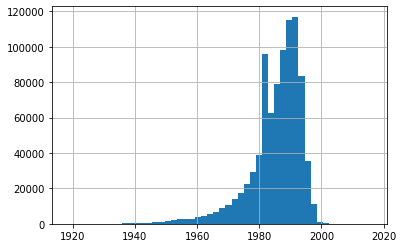

In [ ]:
data1.CustomerDOB.hist(bins = 50)

Now the distribution of birthdays makes sense. As we expected, there is a peak in 1981. However, this shouldn't compromise the hashing procedure. 

#### Transaction Time

In [ ]:
from datetime import datetime

In [ ]:
#Transaction time is not in the format we want
data1['TransactionTime'] = data1.TransactionTime.apply(lambda row: datetime.strptime(str(row).zfill(6), '%H%M%S'))

In [ ]:
data1.TransactionTime.dt.time

0         01:12:29
1         20:44:09
2         22:03:05
3         17:02:54
4         14:11:03
            ...   
879354    00:51:22
879355    12:02:55
879356    12:25:33
879357    21:37:22
879358    22:57:32
Name: TransactionTime, Length: 879359, dtype: object

#### Transaction Date

In [ ]:
data1['TransactionDate'] = pd.to_datetime(data1.TransactionDate)

In [ ]:
data1.TransactionDate[29]

Timestamp('2016-11-08 00:00:00')

### 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by **finding similar behaviours** among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study

#### 1.1 Set up the data

In [ ]:
#the dataset we are going to use has been already prepared
data

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5
...,...,...,...,...,...,...,...
1041608,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,184824,799.0
1041609,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0
1041610,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0
1041611,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0


#### 1.2 Fingerprint hashing

*1. Implement your minhash function from scratch*

The min-hash function has as input a set of shingles and, as output, the so-called **signature matrix**. We want to create it.The signatures we desire to construct for sets are composed of the results of a
large number of calculations, say several hundred, each of which is a “minhash”
of the characteristic matrix.
Hence, the first thing we need to do is obtaining the characteristic matrix associated to our dataset. 

Build the characteristic matrix
- Step 1 : Feature discretization
- step 2 : 

#### STEP 1: Feature discretization

For what concern the transaction date it is not interesting to keep all the info for finding similar customers. Two customers can be related if they do transactions in the same period of the year, so we can consider for example the month of the transaction (e.g. customers buying something during Christmas are considered similar). 
Also for the transaction time the reasoning is similar: we keep only the transaction hour. 


For reducing the number of the shingles without losing any important information (and for avoiding ambiguous shingles) we can use as shingles the period of the year and of the day.
For example, we replace the range of hours from 6 to 13 simply in morning (two customers are considered similar if they prefer to do trasaction during the morning. It is not important if one did it at 11 and the other at 12!). 

Since what we want is creating a finite set of shingles (we will use unigrams), we need to discretize the features. It's the same principle of what we did in the previous cell: instead of a quantitative feature (that seems to specific for each customer) we need a set of few qualitative features. For doing it, we use a sklearn function: sklearn.preprocessing.KBinsDiscetizer

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

The features we want to discretize are: 
- the balance of the customer
- the period of the year (retrieved from the TransactionDate column)
- the period of the day (retrieved from the TransactionTime column)
- the amount of the transaction

In [ ]:
#balance account
balance = KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'uniform')

In [ ]:
balance.fit(data1.CustAccountBalance.to_numpy().reshape(-1,1))

KBinsDiscretizer(encode='ordinal', n_bins=4, strategy='uniform')

In [ ]:
data1['discrete_balance'] = balance.transform(data1.CustAccountBalance.to_numpy().reshape(-1,1))

In [ ]:
data1.discrete_balance.value_counts()


0.0    879239
1.0        89
2.0        21
3.0        10
Name: discrete_balance, dtype: int64

In [ ]:
print('min_class 0:', data1.loc[data1['discrete_balance'] == 0.0, 'CustAccountBalance'].min())
print('max_class 0:', data1.loc[data1['discrete_balance'] == 0.0, 'CustAccountBalance'].max())
print('min_class 1:', data1.loc[data1['discrete_balance'] == 1.0, 'CustAccountBalance'].min())
print('max_class 1:', data1.loc[data1['discrete_balance'] == 1.0, 'CustAccountBalance'].max())
print('min_class 2:', data1.loc[data1['discrete_balance'] == 2.0, 'CustAccountBalance'].min())
print('max_class 2:', data1.loc[data1['discrete_balance'] == 2.0, 'CustAccountBalance'].max())
print('min_class 3:', data1.loc[data1['discrete_balance'] == 3.0, 'CustAccountBalance'].min())
print('max_class 3:', data1.loc[data1['discrete_balance'] == 3.0, 'CustAccountBalance'].max())


min_class 0: 0.0
max_class 0: 28690630.58
min_class 1: 31128912.59
max_class 1: 55369688.16
min_class 2: 69799329.59
max_class 2: 82244629.9
min_class 3: 115035495.1
max_class 3: 115035495.1


We split the account balances in 4 bins 0, 1, 2 and 3, from the lowest to the greater balances. 

The function we used is useful but in practice we can't use it for each feature. As a matter of fact, there is no way to give labels to bins. To avoid ambiguity among shingles we use another method. 

In [ ]:
data1.columns


Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance',
       'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)',
       'discrete_balance'],
      dtype='object')

In [ ]:
#period of the year
labels = ['Jan-Mar', 'Apr-Jun', 'Jul-Sept', 'Oct-Dec']
data1['period_year'] = pd.cut(data1['TransactionDate'].dt.month,  4, labels = labels)

In [ ]:
data1.period_year.value_counts()

Jul-Sept    537647
Oct-Dec     122379
Apr-Jun     111939
Jan-Mar     107394
Name: period_year, dtype: int64

In [ ]:
data1.loc[data1['period_year']=='Oct-Dec', 'TransactionDate' ].dt.month.value_counts()

10    44195
11    41258
12    36926
Name: TransactionDate, dtype: int64

In [ ]:
#period of the day
labels = ['Night','Morning', 'Afternoon', 'Late evening']
data1['period_day'] = pd.cut(data1['TransactionTime'].dt.hour, 4, labels = labels)

In [ ]:
data1.loc[data1['period_day']=='Night', 'TransactionTime' ].dt.hour.value_counts()

0    15240
1     7453
2     4647
5     4398
3     3883
4     3706
Name: TransactionTime, dtype: int64

In [ ]:
data1.period_day.value_counts()

Late evening    366148
Afternoon       327389
Morning         146495
Night            39327
Name: period_day, dtype: int64

In [ ]:
data1['TransactionAmount (INR)'].describe()

count    8.793590e+05
mean     1.564485e+03
std      6.637781e+03
min      0.000000e+00
25%      1.600000e+02
50%      4.560000e+02
75%      1.200000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

In [ ]:
#amount of the transaction
labels = ['Small','Medium', 'Big']
data1['transaction_size'] = pd.qcut(data1['TransactionAmount (INR)'], q =3, labels = labels)

In [ ]:
data1.transaction_size.value_counts()

Small     294800
Big       292901
Medium    291658
Name: transaction_size, dtype: int64

In [ ]:
#Medium transactions
data1.loc[data1['transaction_size']=='Medium', 'TransactionAmount (INR)' ].describe()

count    291658.000000
mean        471.446172
std         172.043970
min         230.020000
25%         309.000000
50%         459.500000
75%         600.000000
max         860.000000
Name: TransactionAmount (INR), dtype: float64

In [ ]:
#Small transactions
data1.loc[data1['transaction_size']=='Small', 'TransactionAmount (INR)' ].describe()

count    294800.000000
mean        103.874653
std          67.527207
min           0.000000
25%          50.000000
50%         100.000000
75%         164.000000
max         230.000000
Name: TransactionAmount (INR), dtype: float64

In [ ]:
data1.loc[data1['transaction_size']=='Big', 'TransactionAmount (INR)' ].describe()

count    2.929010e+05
mean     4.122966e+03
std      1.106176e+04
min      8.600100e+02
25%      1.200000e+03
50%      1.890000e+03
75%      3.400000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

For what concerns the date of birth, it is not very useful to keep the whole date, but maybe the age of the customer is more useful. 

In [ ]:
data1['cust_age'] = 2016 - data1.CustomerDOB.dt.year 

In [ ]:
data1.cust_age.value_counts()

35    70658
26    61325
25    60122
27    58292
24    56254
      ...  
0         2
96        2
98        1
91        1
5         1
Name: cust_age, Length: 99, dtype: int64

Now, for each column, the values are categorical. Keep only discrete 

In [ ]:
data1.columns

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance',
       'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)',
       'PeriodoftheDay', 'discrete_balance', 'period_year', 'period_day',
       'transaction_size', 'cust_age'],
      dtype='object')

In [ ]:
# Keep only discrete features
discr_df = data1[['CustGender', 'CustLocation', 'CustAccountBalance', 'discrete_balance', 'period_year', 'period_day', 'transaction_size', 'cust_age' ]]

In [ ]:
#create a pickle file containing the modified dataset
import pickle
with open('modified_df.pkl', 'wb') as f:
    pickle.dump(discr_df, f)

In [ ]:
discr_df

,CustGender,CustLocation,CustAccountBalance,discrete_balance,period_year,period_day,transaction_size,cust_age
0,M,NEW DELHI,120180.54,0.0,Jul-Sept,Night,Medium,33
1,M,MUMBAI,24204.49,0.0,Jul-Sept,Late evening,Big,22
2,M,MUMBAI,161848.76,0.0,Jul-Sept,Late evening,Medium,32
3,F,CHAMPARAN,496.18,0.0,Jul-Sept,Afternoon,Small,26
4,M,KOLKATA,87058.65,0.0,Jul-Sept,Afternoon,Big,51
...,...,...,...,...,...,...,...,...
879354,M,BHIWANDI,133067.23,0.0,Jul-Sept,Night,Medium,26
879355,M,BANGALORE,96063.46,0.0,Jul-Sept,Afternoon,Small,20
879356,M,GUNTUR,5559.75,0.0,Jul-Sept,Afternoon,Small,23
879357,M,CHENNAI,35295.92,0.0,Jul-Sept,Late evening,Small,21


We have 879359 rows. Trhough them we have to retrieve the shingles.

#### STEP 2: Shingling

In [ ]:
all_unique_values = []
for column in discr_df:
  values = discr_df[column].unique().tolist()
  set_values = set(values)
  unique_values = list(set_values)
  all_unique_values.append(unique_values)
#print(all_unique_values)

[['F', 'M', 'T'], ['PALGHAR', 'TRICHY DT', 'DIST VALSAD', 'ANDHERI (WEST) MUMBAI', 'OSHIWARA ANDHERI WEST MUMBAI', 'GANGANAGAR', 'KURLA ROAD SAKINAKA MUMBAI', 'KARORA', 'DEHRI ON SONE', 'FUNCTION HALL VAYUPURI HYDERABAD', 'VAPADA', 'ELPHINSTONE WEST MUMBAI', 'MADIPAKKAM', 'AMIRCHAND HIGHSCHOOL MUMBAI', 'KOTAGIRI', 'MOTOR HYDERABAD', 'UPLANDS VISAKHAPATNAM', 'PATRAPUR', 'GODHRA', 'HYDERSHAH KOTE RAJENDRA HYDERABAD', 'SAWANTWADI', 'NALGONDA DIST', 'GUNTUR', 'N T PUNE', 'OUTRAM', 'JOGESHWARI E MUMBAI', 'JUINGR RAILWAY STATION NAVI MUMBAI', 'AMBERNATH EAST', 'NARASARAOPET GUNTUR', 'WEST KALYAN THANE', 'STAND CHENNAI', 'SOCIETY GATE MUMBAI', 'KANCHIPURAM', 'HEALTH CLUB HOSHANGABAD', 'QUEPEM GA', 'GARDEN MUMBAI', 'COMPLEX KALYAN W', 'KORAMANGALA 1ST BLOCK BANGALORE', 'DOMBIVLI THANE', 'BANDRA (E) MUMBAI', 'COLLEGE KANPUR', 'BHADRAK', 'LINK RD GOREGAON W MUMBAI', 'ELCO MARKET BANDRA (W) MUMBAI', 'JAGATSINGHAPUR', 'RAJGANGPUR', 'PAREL WEST MUMBAI', 'KILKATA', 'RENTON', 'KEONJHAR', 'PARK CHURCH

In [ ]:
unique_data = [x[i] for x in all_unique_values for i in range(len(x))]


In [ ]:
print('the number of unique unigrams is: ', len(unique_data))

the number of unique unigrams is:  162793


In [ ]:
#create a pickle file containing the list of shingles
import pickle
with open('shingles.pkl', 'wb') as f:
    pickle.dump(unique_data, f)

#### STEP 3: Create the characteristic matrix

In [ ]:
import pickle

In [ ]:
#open the pickle file
with open('modified_df.pkl', 'rb') as f:
    modified_df = pickle.load(f)

In [ ]:
#open the pickle file
with open('shingles.pkl', 'rb') as f:
    shingles = pickle.load(f)

In [ ]:
modified_df

,CustGender,CustLocation,CustAccountBalance,discrete_balance,period_year,period_day,transaction_size,cust_age
0,M,NEW DELHI,120180.54,0.0,Jul-Sept,Night,Medium,33
1,M,MUMBAI,24204.49,0.0,Jul-Sept,Late evening,Big,22
2,M,MUMBAI,161848.76,0.0,Jul-Sept,Late evening,Medium,32
3,F,CHAMPARAN,496.18,0.0,Jul-Sept,Afternoon,Small,26
4,M,KOLKATA,87058.65,0.0,Jul-Sept,Afternoon,Big,51
...,...,...,...,...,...,...,...,...
879354,M,BHIWANDI,133067.23,0.0,Jul-Sept,Night,Medium,26
879355,M,BANGALORE,96063.46,0.0,Jul-Sept,Afternoon,Small,20
879356,M,GUNTUR,5559.75,0.0,Jul-Sept,Afternoon,Small,23
879357,M,CHENNAI,35295.92,0.0,Jul-Sept,Late evening,Small,21


In [ ]:
shingles

In [ ]:
import numpy as np

In [ ]:
#we create a numpy array 
char_arr = []
for customer in enumerate(modified_df.values):     #at each iteration costumer is a list coprint(len(customer))
  for shingle in shingles:
    print(customer)
    print(shingle)



In [ ]:
#create a pickle file containing the vocabulary
import pickle
with open('characteristic_matrix.pkl', 'wb') as f:
    pickle.dump(char_arr, f)

In [ ]:
#open the pickle file
with open('characteristic_matrix.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)